In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


setup sessão spark (grande volume de dados)

In [ ]:
# # instalar as dependências
# !apt-get update -qq
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
# !tar xf spark-3.1.2-bin-hadoop2.7.tgz
# !pip install -q findspark

In [ ]:
!apt-get update -qq
!apt-get install -y -qq openjdk-17-jdk-headless
!pip install -q pyspark==3.5.1 findspark py4j==0.10.9.7

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
import os, findspark
# Garanta Java 17 e Python 3
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"

# (Se você já setou SPARK_HOME antes, limpe para evitar conflito)
os.environ.pop("SPARK_HOME", None)

findspark.init()

In [ ]:
# import findspark
# findspark.init()

In [ ]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder \
#     .master('local[*]') \
#     .appName("ChurnCase") \
#     .getOrCreate()

In [ ]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("ChurnCase-HighVolume")
    .master("local[*]")  # usa todos os cores
    # Memória do driver — ajuste se necessário (ex.: "20g")
    .config("spark.driver.memory", "16g")
    # Serializer rápido
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    # Adaptive Query Execution (ajusta planos/partições em runtime)
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.sql.adaptive.skewJoin.enabled", "true")
    # Shuffle partitions (base): diminua/ajuste se operações ficam lentas
    .config("spark.sql.shuffle.partitions", "200")
    # Broadcast joins p/ dimensões médias
    .config("spark.sql.autoBroadcastJoinThreshold", "64MB")
    # Compressões
    .config("spark.io.compression.codec", "lz4")
    .config("spark.sql.parquet.compression.codec", "zstd")
    # Parquet otimizações
    .config("spark.sql.parquet.mergeSchema", "false")
    .config("spark.sql.parquet.filterPushdown", "true")
    .config("spark.sql.files.maxPartitionBytes", str(256 * 1024 * 1024))  # ~256MB p/ partição
    # Pandas <-> Arrow (quando for coletar amostras para gráficos)
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    # UI menos verbosa
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
print("Spark:", spark.version)


Spark: 3.5.1


In [ ]:
import kagglehub
import os
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count,  to_date, year, month, datediff, concat_ws, lit, last_day,  mean, stddev, min, max
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Importação de Dados


Origem dados: Kaggle - importação via kaggle


In [ ]:
# baixar dados da pasta do data master
path = kagglehub.dataset_download("gcenachi/case-data-master-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'case-data-master-2024' dataset.
Path to dataset files: /kaggle/input/case-data-master-2024


avaliação arquivos disponíveis no diretório Kaggle

In [ ]:
# Ver tudo que foi baixado
print("Arquivos encontrados:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

Arquivos encontrados:
/kaggle/input/case-data-master-2024/members.parquet
/kaggle/input/case-data-master-2024/user_logs.parquet
/kaggle/input/case-data-master-2024/transactions.parquet


In [ ]:
print("DIretório dos dados: "+path)

DIretório dos dados: /kaggle/input/case-data-master-2024


In [ ]:
#leitura dos dados
df_transactions = spark.read.parquet(f"{path}/transactions.parquet")
df_members = spark.read.parquet(f"{path}/members.parquet")
df_user_logs = spark.read.parquet(f"{path}/user_logs.parquet")

In [ ]:
df_transactions.show(5)
df_members.show(5)
df_user_logs.show(5)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel| safra|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSk...|               38|              410|           1788|              1788|            0|        20151121|              20170104|        0|201511|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150526|              20150626|        0|201505|
|+++snpr7pmobhLKUg...|               41|               30|            149|               149|            1|        20150926|              20151026|        0|201509|
|++/9R3sX3

* A base transactions possui informações de registros de pagamentos, valores, datas de transação
* A base member possui informaçoes de registro e demograficas dos clientes
* A base user logs possui informaões de uso da plataforma pelos clientes

Avaliação quantidade de registros por Safra

In [ ]:

 df_members.groupBy("safra").count().orderBy("safra").show()


+------+-------+
| safra|  count|
+------+-------+
|201601|4294184|
|201602|4502354|
|201603|4697972|
|201604|4876301|
|201605|5060705|
|201606|5250064|
|201607|5439337|
|201608|5615921|
|201609|5778986|
|201610|5949288|
|201611|6114345|
|201612|6287789|
+------+-------+



In [ ]:
df_transactions.groupBy("safra").count().orderBy("safra").show(100)


+------+-------+
| safra|  count|
+------+-------+
|201501| 548792|
|201502| 545303|
|201503| 626488|
|201504| 564582|
|201505| 571552|
|201506| 775737|
|201507| 665280|
|201508| 705975|
|201509| 714610|
|201510| 680465|
|201511| 820345|
|201512| 861107|
|201601| 856716|
|201602| 792300|
|201603| 775469|
|201604| 774169|
|201605| 783956|
|201606| 804729|
|201607| 924032|
|201608| 966450|
|201609| 982640|
|201610|1033898|
|201611|1094941|
|201612| 968547|
|201701| 988576|
|201702| 885566|
+------+-------+



In [ ]:
df_user_logs.groupBy("safra").count().orderBy("safra").show(100)


+------+-------+
| safra|  count|
+------+-------+
|201501| 937789|
|201502| 933040|
|201503| 944739|
|201504| 939930|
|201505| 924216|
|201506| 916862|
|201507| 871491|
|201508| 920129|
|201509| 903194|
|201510|1012953|
|201511|1041975|
|201512|1039271|
|201601|1076712|
|201602|1041248|
|201603|1048941|
|201604|1042406|
|201605|1056491|
|201606|1081181|
|201607|1102807|
|201608|1103078|
|201609|1112601|
|201610|1139089|
|201611|1183088|
|201612|1135573|
|201701|1136003|
|201702|1114164|
+------+-------+



In [ ]:
df_transactions.count()

20712225

In [ ]:
df_members.count()

63867246

In [ ]:
df_user_logs.count()

26758971

In [ ]:
#avaliação se há duplicatas nos registros por membro dentro de uma mesma safra
print(df_members.filter(F.col("safra") == 201612 ).select("msno").distinct().count())
print(df_members.filter(F.col("safra") == 201612).count())

6287789
6287789


In [ ]:
df_user_logs.count()

26758971

A base members possuí registros mensais de todas as safras de 2016. As outras bases possuem registros de 12m antes da primeira safra de members e 3 meses após a última.

#Exploratória

## Base Members

* Volume de clientes por mês (safra)

* Evolução do número de clientes ao longo do tempo

* Distribuição de idade, sexo, país de origem, método de registro

* Clientes novos por mês (is_new se existir ou criar com base no registration_init_time)

* Tempo desde o registro até a safra

In [ ]:
df_members = spark.read.parquet(f"{path}/members.parquet")

In [ ]:
df_members.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)



### Avaliação de nulos

In [ ]:
#contagem de nulos
df_members.select([
    (count(when(col(c).isNull() | isnan(col(c)), c)) / df_members.count()).alias(f"{c}_pct_null")
    for c in df_members.columns
]).show()

+-------------+--------------+-------------------------------+-------------+-----------+------------------+-----------------------+-----------------+
|msno_pct_null|safra_pct_null|registration_init_time_pct_null|city_pct_null|bd_pct_null|   gender_pct_null|registered_via_pct_null|is_ativo_pct_null|
+-------------+--------------+-------------------------------+-------------+-----------+------------------+-----------------------+-----------------+
|          0.0|           0.0|                            0.0|          0.0|        0.0|0.5982750062528138|                    0.0|              0.0|
+-------------+--------------+-------------------------------+-------------+-----------+------------------+-----------------------+-----------------+



A Coluna de genero apresentou grande proporção de nulos. Seráfeita uma analise dessa coluna em relação a taxa de churn para decisão se ela sera utilizada no modelo.

### Volume de registros por mês

In [ ]:
from pyspark.sql import functions as F

df_members.groupBy("safra").agg(
    F.count("*").alias("registros"),
    F.countDistinct("msno").alias("ids_unicos")
).orderBy("safra").show()

+------+---------+----------+
| safra|registros|ids_unicos|
+------+---------+----------+
|201601|  4294184|   4294184|
|201602|  4502354|   4502354|
|201603|  4697972|   4697972|
|201604|  4876301|   4876301|
|201605|  5060705|   5060705|
|201606|  5250064|   5250064|
|201607|  5439337|   5439337|
|201608|  5615921|   5615921|
|201609|  5778986|   5778986|
|201610|  5949288|   5949288|
|201611|  6114345|   6114345|
|201612|  6287789|   6287789|
+------+---------+----------+



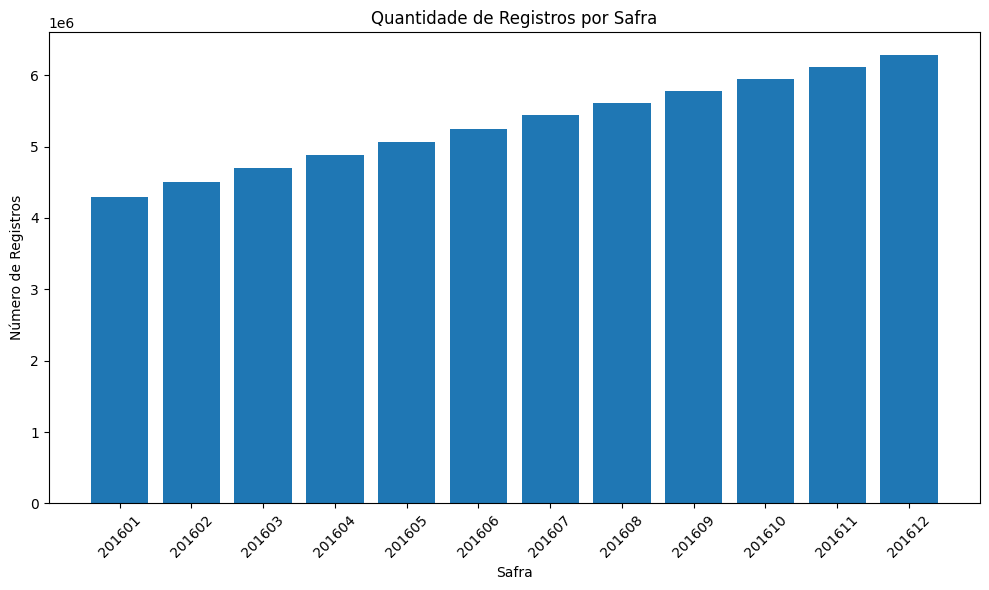

In [ ]:

safra_counts_df = df_members.groupBy("safra").count().orderBy("safra").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(safra_counts_df["safra"], safra_counts_df["count"])
plt.xlabel("Safra")
plt.ylabel("Número de Registros")
plt.title("Quantidade de Registros por Safra")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Gênero


In [ ]:
df_members.groupBy("gender").count().orderBy("count", ascending=False).show()

+------+--------+
|gender|   count|
+------+--------+
|  NULL|38210177|
|  male|13075425|
|female|12581644|
+------+--------+



In [ ]:
df_city_churn = df_members.groupBy("gender").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+------+--------+--------+------------+
|gender|   total|inativos|pct_inativos|
+------+--------+--------+------------+
|  NULL|38210177|32756213|       85.73|
|female|12581644| 9829354|       78.12|
|  male|13075425|10038814|       76.78|
+------+--------+--------+------------+



### Idade

In [ ]:
df_members.show(5)

+--------------------+------+----------------------+----+---+------+--------------+--------+
|                msno| safra|registration_init_time|city| bd|gender|registered_via|is_ativo|
+--------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUg...|201612|              20140927|   1|  0|  NULL|             7|       1|
|++/AwGzubug3gT6J+...|201607|              20150322|   1|  0|  NULL|             9|       0|
|++/Gw1B9K+XOlB3hL...|201601|              20121217|  15| 32|  male|             3|       1|
|++02XbtviomSxcIBU...|201603|              20131112|  14| 21|  male|             7|       0|
|++0O0Bq04sB/9ZcOS...|201610|              20141021|   5| 33|  male|             3|       0|
+--------------------+------+----------------------+----+---+------+--------------+--------+
only showing top 5 rows



apesar do nome birthday date (bd) a variavel traz uma informação numérica

In [ ]:
df_members.select("bd").describe().show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63867246|
|   mean|11.430160210759675|
| stddev| 19.04131838798387|
|    min|               -10|
|    max|               994|
+-------+------------------+



In [ ]:
total = df_members.count()

# Idade zero ou negativa
qtd_baixa = df_members.filter(col("bd") <= 0).count()
pct_baixa = qtd_baixa / total * 100

# Idade muito alta
qtd_alta = df_members.filter(col("bd") > 100).count()
pct_alta = qtd_alta / total * 100

print(f"Idades ≤ 0: {qtd_baixa} registros ({pct_baixa:.2f}%)")
print(f"Idades > 100: {qtd_alta} registros ({pct_alta:.2f}%)")


Idades ≤ 0: 39512942 registros (61.87%)
Idades > 100: 56654 registros (0.09%)


In [ ]:
df_safra = df_members.filter(
    (col("safra") == "201612")
)

# Criar coluna com faixa etária
df_safra = df_safra.withColumn(
    "faixa_etaria",
    when(col("bd") < 0, "abaixo de 0")
    .when(col("bd") == 0, "0")
    .when(col("bd") < 10, "0-9")
    .when(col("bd") < 20, "10-19")
    .when(col("bd") < 30, "20-29")
    .when(col("bd") < 40, "30-39")
    .when(col("bd") < 50, "40-49")
    .when(col("bd") < 60, "50-59")
    .when(col("bd") < 70, "60-69")
    .when(col("bd") < 80, " 70-79")
    .when(col("bd") < 90, " 80-89")
    .when(col("bd") < 120, " 90-120")
    .otherwise("a partir de 120")
)

df_safra.groupBy("faixa_etaria").count().orderBy("faixa_etaria").show()


+---------------+-------+
|   faixa_etaria|  count|
+---------------+-------+
|          70-79|   3801|
|          80-89|   1400|
|         90-120|   7055|
|              0|4139317|
|            0-9|    895|
|          10-19| 308444|
|          20-29| 950801|
|          30-39| 538022|
|          40-49| 235528|
|          50-59|  81769|
|          60-69|  20116|
|a partir de 120|    368|
|    abaixo de 0|    273|
+---------------+-------+



Existe um percentual alto de zeros assim como alguns casos negativos, menores de idade e idades muito altas. Sera feita uma avaliação da importância dessa variavel na etapa de featuring

distribuição idade por safra a procura de anomalias

In [ ]:
df_idade_filtrada = df_members.filter(
    (col("bd") >= 10) & (col("bd") <= 120)
).select("safra", "bd")

# Amostra aleatória de 10% da base com seed para reprodutibilidade
df_members_amostra = df_idade_filtrada.sample(withReplacement=False, fraction=0.3, seed=42)


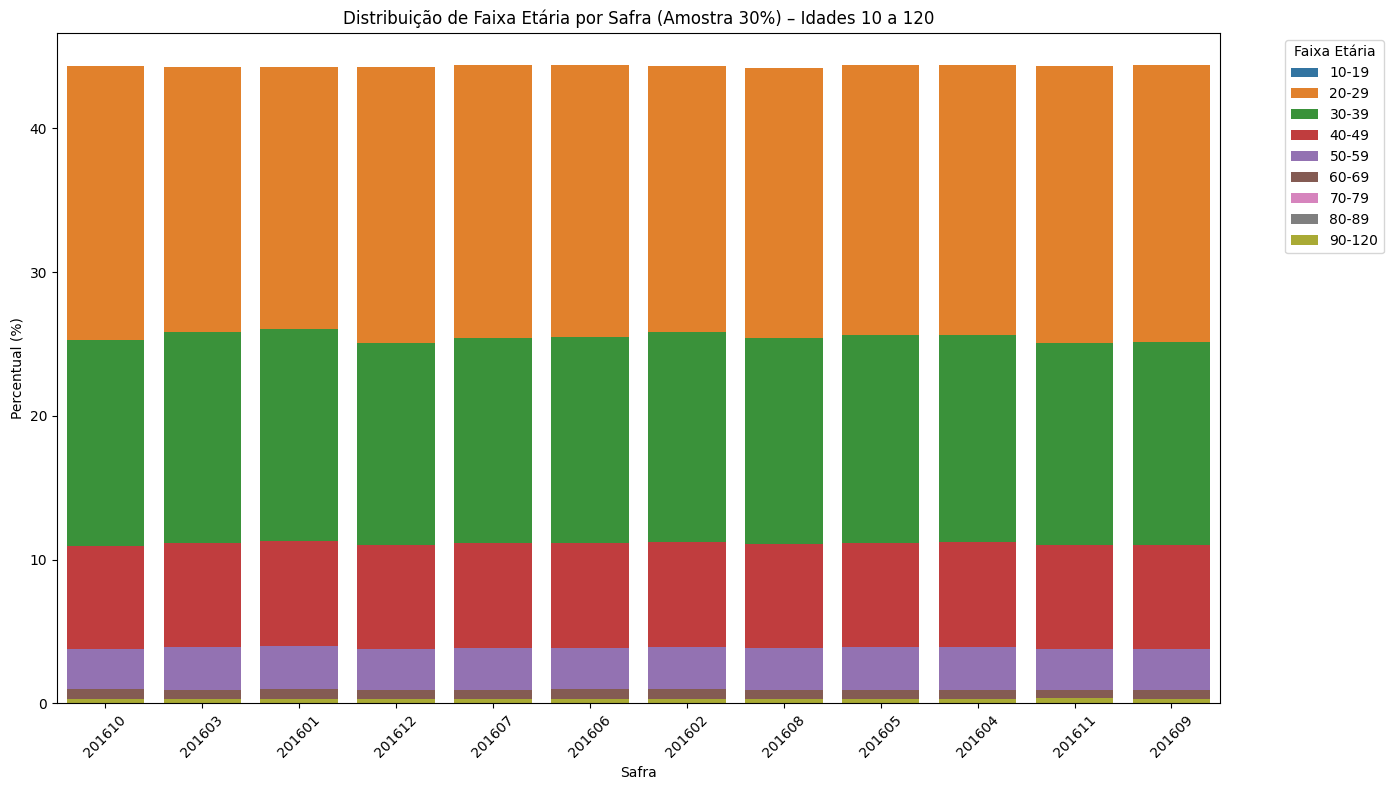

In [ ]:
# Repetir o bucket de faixa etária (caso ainda não tenha sido feito)
from pyspark.sql.functions import when

df_safra_amostra = df_members_amostra.withColumn(
    "faixa_etaria",
    when(col("bd") < 20, "10-19")
    .when(col("bd") < 30, "20-29")
    .when(col("bd") < 40, "30-39")
    .when(col("bd") < 50, "40-49")
    .when(col("bd") < 60, "50-59")
    .when(col("bd") < 70, "60-69")
    .when(col("bd") < 80, "70-79")
    .when(col("bd") < 90, "80-89")
    .otherwise("90-120")
)

# Agrupar faixa x safra
df_safra_faixa = df_safra_amostra.groupBy("safra", "faixa_etaria").count().cache()
# df_safra_faixa.count()

#Converter para Pandas
df_safra_faixa_pd = df_safra_faixa.toPandas()
df_safra_faixa_pd['faixa_etaria'] = df_safra_faixa_pd['faixa_etaria'].str.strip()
df_safra_faixa_pd['percentual'] = df_safra_faixa_pd.groupby('safra')['count'].transform(lambda x: x / x.sum() * 100)

# Ordem correta das faixas
faixa_etaria_order = ["10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-120"]
df_safra_faixa_pd['faixa_etaria'] = pd.Categorical(df_safra_faixa_pd['faixa_etaria'], categories=faixa_etaria_order, ordered=True)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.barplot(data=df_safra_faixa_pd, x="safra", y="percentual", hue="faixa_etaria", dodge=False)
plt.xlabel("Safra")
plt.ylabel("Percentual (%)")
plt.title("Distribuição de Faixa Etária por Safra (Amostra 30%) – Idades 10 a 120")
plt.xticks(rotation=45)
plt.legend(title="Faixa Etária", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#avaliação da proporção de churn na safra de 201612
df_bd_churn = df_safra.groupBy("faixa_etaria").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+---------------+-------+--------+------------+
|   faixa_etaria|  total|inativos|pct_inativos|
+---------------+-------+--------+------------+
|         90-120|   7055|    6517|       92.37|
|          70-79|   3801|    3449|       90.74|
|          80-89|   1400|    1266|       90.43|
|          10-19| 308444|  272988|        88.5|
|              0|4139317| 3632234|       87.75|
|          60-69|  20116|   17545|       87.22|
|            0-9|    895|     755|       84.36|
|          50-59|  81769|   67946|        83.1|
|          40-49| 235528|  192987|       81.94|
|          20-29| 950801|  716276|       75.33|
|          30-39| 538022|  396623|       73.72|
|    abaixo de 0|    273|     189|       69.23|
|a partir de 120|    368|     215|       58.42|
+---------------+-------+--------+------------+



### Cidade

In [ ]:
#contagem distinta

df_members.select("city").distinct().count()

21

In [ ]:
df_members.groupBy("city").count().orderBy("count", ascending=False).show(21)

+----+--------+
|city|   count|
+----+--------+
|   1|41955263|
|   5| 4271348|
|  13| 3650065|
|   4| 2730740|
|  22| 2328925|
|  15| 2123349|
|   6| 1492818|
|  14| 1004416|
|  12|  740584|
|   9|  538369|
|  11|  529654|
|   8|  506488|
|  18|  424839|
|  10|  362007|
|  21|  342973|
|  17|  308525|
|   3|  303161|
|   7|  135492|
|  16|   57166|
|  20|   47238|
|  19|   13826|
+----+--------+



In [ ]:
df_city_churn = df_members.groupBy("city").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+----+--------+--------+------------+
|city|   total|inativos|pct_inativos|
+----+--------+--------+------------+
|   1|41955263|36969118|       88.12|
|  19|   13826|   11842|       85.65|
|  20|   47238|   37273|        78.9|
|   8|  506488|  392564|       77.51|
|  11|  529654|  406838|       76.81|
|  21|  342973|  262678|       76.59|
|  12|  740584|  564561|       76.23|
|  17|  308525|  233816|       75.79|
|  16|   57166|   43304|       75.75|
|   6| 1492818| 1123888|       75.29|
|   3|  303161|  227287|       74.97|
|   5| 4271348| 3173684|        74.3|
|  22| 2328925| 1724954|       74.07|
|   4| 2730740| 2015945|       73.82|
|   7|  135492|   99819|       73.67|
|  18|  424839|  312386|       73.53|
|  10|  362007|  265525|       73.35|
|  14| 1004416|  711291|       70.82|
|   9|  538369|  380579|       70.69|
|  15| 2123349| 1498729|       70.58|
|  13| 3650065| 2168300|        59.4|
+----+--------+--------+------------+



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Canal de registro

In [ ]:
df_members.groupBy("registered_via").count().orderBy("count", ascending=False).show()

+--------------+--------+
|registered_via|   count|
+--------------+--------+
|             4|19648219|
|             3|18640987|
|             9|16776651|
|             7| 8407395|
|            11|  269614|
|             8|   47588|
|             5|   18715|
|             2|   16847|
|            16|   10564|
|            13|    7546|
|            14|    7111|
|            17|    6630|
|            19|    5629|
|             6|    3380|
|             1|     254|
|            10|     104|
|            -1|      12|
+--------------+--------+



Percentual de inativos

In [ ]:
df_city_churn = df_members.groupBy("registered_via").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_city_churn.orderBy("pct_inativos", ascending=False).show(22)

+--------------+--------+--------+------------+
|registered_via|   total|inativos|pct_inativos|
+--------------+--------+--------+------------+
|            11|  269614|  269614|       100.0|
|             8|   47588|   47588|       100.0|
|             5|   18715|   18715|       100.0|
|            17|    6630|    6630|       100.0|
|             6|    3380|    3380|       100.0|
|            19|    5629|    5629|       100.0|
|             1|     254|     254|       100.0|
|            14|    7111|    7111|       100.0|
|             2|   16847|   16847|       100.0|
|            -1|      12|      12|       100.0|
|            16|   10564|   10563|       99.99|
|             4|19648219|18989293|       96.65|
|             3|18640987|16970608|       91.04|
|            10|     104|      94|       90.38|
|             9|16776651|13071918|       77.92|
|             7| 8407395| 3205719|       38.13|
|            13|    7546|     406|        5.38|
+--------------+--------+--------+------

In [ ]:
#percentual de nulos
total = df_members.count()
nulos = df_members.filter(col("registered_via").isNull()).count()
print(f"Nulos: {nulos} registros ({nulos/total*100:.2f}%)")


Nulos: 0 registros (0.00%)


### Início do registro

In [ ]:
df_members = df_members.withColumn("registration_date", to_date(col("registration_init_time").cast("string"), "yyyyMMdd"))

In [ ]:
df_members.groupBy("registration_date").count().orderBy("registration_date").show(10, truncate=False)


+-----------------+-----+
|registration_date|count|
+-----------------+-----+
|2004-03-26       |3000 |
|2004-03-27       |17772|
|2004-03-28       |13308|
|2004-03-29       |8712 |
|2004-03-30       |4932 |
|2004-03-31       |3372 |
|2004-04-01       |1872 |
|2004-04-02       |1536 |
|2004-04-03       |1428 |
|2004-04-04       |1044 |
+-----------------+-----+
only showing top 10 rows



In [ ]:
df_members.groupBy(year("registration_date").alias("ano"), month("registration_date").alias("mes")) \
    .count().orderBy("ano", "mes").show()

+----+---+------+
| ano|mes| count|
+----+---+------+
|2004|  3| 51096|
|2004|  4| 17004|
|2004|  5|  5232|
|2004|  6|  6600|
|2004|  7| 56556|
|2004|  8| 29688|
|2004|  9| 39876|
|2004| 10| 54564|
|2004| 11| 36900|
|2004| 12| 17292|
|2005|  1| 16584|
|2005|  2| 30240|
|2005|  3| 33024|
|2005|  4| 25584|
|2005|  5| 23268|
|2005|  6| 23916|
|2005|  7| 26124|
|2005|  8| 24636|
|2005|  9| 60648|
|2005| 10|103704|
+----+---+------+
only showing top 20 rows



In [ ]:
df_members = df_members.withColumn(
    "safra_date",
    last_day(
        to_date(
            concat_ws("-",
                      col("safra").cast("string").substr(1, 4),
                      col("safra").cast("string").substr(5, 2),
                      lit("01")
            )
        )
    )
)

In [ ]:
df_members = df_members.withColumn(
    "dias_na_base",
    datediff(col("safra_date"), col("registration_date"))
)

In [ ]:
df_members.filter(col("dias_na_base") < 0).count()

0

In [ ]:
df_members = df_members.withColumn(
    "ano_registro",
    year(col("registration_date"))
)

In [ ]:
df_members = df_members.withColumn(
    "mes_registro",
    month(col("registration_date"))
)

In [ ]:
#avaliação da proporção de churn por safra de registro
df_bd_churn = df_members.groupBy(year("registration_date").alias("ano"), month("registration_date").alias("mes")).agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(20)

df_bd_churn.orderBy("pct_inativos", ascending=True).show(20)

+----+---+-------+--------+------------+
| ano|mes|  total|inativos|pct_inativos|
+----+---+-------+--------+------------+
|2016|  4|1604961| 1476708|       92.01|
|2015|  1|1227480| 1118186|        91.1|
|2015|  2|1113480| 1011252|       90.82|
|2014| 11|1249104| 1133087|       90.71|
|2014| 10|1251108| 1134418|       90.67|
|2016| 10| 510906|  462488|       90.52|
|2014|  9| 977748|  884086|       90.42|
|2014|  8|1021800|  923113|       90.34|
|2014|  6|1040940|  939151|       90.22|
|2015|  6| 950004|  857031|       90.21|
|2015|  3|1144656| 1030931|       90.06|
|2014| 12|1152696| 1035343|       89.82|
|2016|  5|1475232| 1324815|        89.8|
|2015|  4| 971208|  871430|       89.73|
|2014|  7| 922848|  827684|       89.69|
|2016| 11| 330114|  295920|       89.64|
|2015| 12|2693124| 2401017|       89.15|
|2016| 12| 173444|  154285|       88.95|
|2014|  5| 912120|  809921|        88.8|
|2016|  6|1325513| 1176255|       88.74|
+----+---+-------+--------+------------+
only showing top

In [ ]:
#avaliação da proporção de churn por ano
df_bd_churn = df_members.groupBy("ano_registro").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+------------+--------+--------+------------+
|ano_registro|   total|inativos|pct_inativos|
+------------+--------+--------+------------+
|        2014|11709312|10387888|       88.71|
|        2016|15374910|13558511|       88.19|
|        2015|19446300|17031817|       87.58|
|        2013| 6296664| 4654062|       73.91|
|        2009|  763596|  521661|       68.32|
|        2008|  812280|  548982|       67.59|
|        2012| 3398280| 2294920|       67.53|
|        2007| 1077960|  697819|       64.74|
|        2006|  647436|  387314|       59.82|
|        2010| 1380900|  822063|       59.53|
|        2004|  314808|  187132|       59.44|
|        2011| 2148612| 1258268|       58.56|
|        2005|  496188|  273944|       55.21|
+------------+--------+--------+------------+



In [ ]:
#avaliação da proporção de churn por mes de registro
df_bd_churn = df_members.groupBy("mes_registro").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+------------+-------+--------+------------+
|mes_registro|  total|inativos|pct_inativos|
+------------+-------+--------+------------+
|           4|4538457| 3812962|       84.01|
|          11|6077406| 5091711|       83.78|
|          10|6215082| 5170611|       83.19|
|           6|4639001| 3856476|       83.13|
|           3|5517948| 4584110|       83.08|
|           5|4477140| 3709944|       82.86|
|          12|5925512| 4897398|       82.65|
|           1|6299892| 5161427|       81.93|
|           2|5590938| 4579874|       81.92|
|           8|5248640| 4278472|       81.52|
|           7|4769670| 3823718|       80.17|
|           9|4567560| 3657678|       80.08|
+------------+-------+--------+------------+



In [ ]:
df_members.select("dias_na_base").describe().show()

+-------+-----------------+
|summary|     dias_na_base|
+-------+-----------------+
|  count|         63867246|
|   mean|778.1843942355054|
| stddev|853.0837348768997|
|    min|                0|
|    max|             4663|
+-------+-----------------+



In [ ]:
df_members = df_members.withColumn(
    "tempo_de_base",
    when(col("dias_na_base") < 30, "<1 mês")
    .when(col("dias_na_base") < 90, "1-3 meses")
    .when(col("dias_na_base") < 180, "3-6 meses")
    .when(col("dias_na_base") < 365, "6-12 meses")
    .otherwise(">1 ano")
)

In [ ]:
#avaliação da proporção de churn por mes de registro
df_bd_churn = df_members.groupBy("tempo_de_base").agg(
    F.count("*").alias("total"),
    F.sum(F.when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
).withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2))

df_bd_churn.orderBy("pct_inativos", ascending=False).show(22)

+-------------+--------+--------+------------+
|tempo_de_base|   total|inativos|pct_inativos|
+-------------+--------+--------+------------+
|       <1 mês| 2208155| 1954410|       88.51|
|    1-3 meses| 4597064| 4053248|       88.17|
|    3-6 meses| 7129334| 6282303|       88.12|
|   6-12 meses|12401239|10805492|       87.13|
|       >1 ano|37531454|29528928|       78.68|
+-------------+--------+--------+------------+



### inativos

In [ ]:
df_churn_safra = df_members.groupBy("safra") \
    .agg(
        count("*").alias("total"),
        F.sum(when(col("is_ativo") == 0, 1).otherwise(0)).alias("inativos")
    ) \
    .withColumn("pct_inativos", F.round(col("inativos") / col("total") * 100, 2)) \
    .orderBy("safra")

In [ ]:
df_churn_safra.show()

+------+-------+--------+------------+
| safra|  total|inativos|pct_inativos|
+------+-------+--------+------------+
|201601|4294184| 3405521|       79.31|
|201602|4502354| 3584238|       79.61|
|201603|4697972| 3826321|       81.45|
|201604|4876301| 4044736|       82.95|
|201605|5060705| 4211052|       83.21|
|201606|5250064| 4405180|       83.91|
|201607|5439337| 4471401|        82.2|
|201608|5615921| 4635278|       82.54|
|201609|5778986| 4787701|       82.85|
|201610|5949288| 4900731|       82.38|
|201611|6114345| 5043232|       82.48|
|201612|6287789| 5308990|       84.43|
+------+-------+--------+------------+



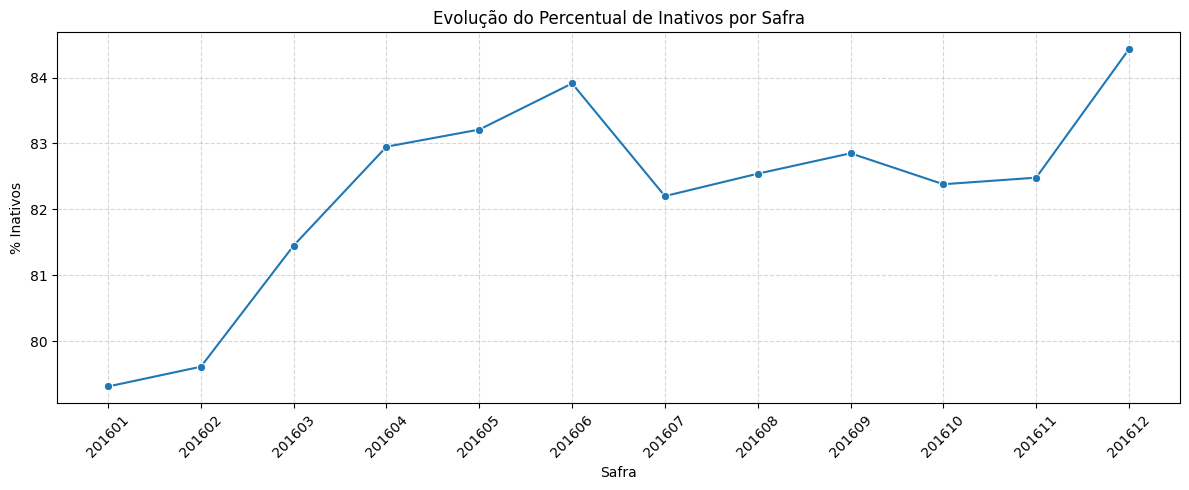

In [ ]:
df_churn_pd = df_churn_safra.toPandas()
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_churn_pd, x="safra", y="pct_inativos", marker="o")
plt.title("Evolução do Percentual de Inativos por Safra")
plt.ylabel("% Inativos")
plt.xlabel("Safra")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Base User logs

Variável	Significado
* msno	Identificador único do usuário
* num_25	Número de músicas ou trechos escutados por pelo menos 25% da duração
* num_50	Número de músicas ou trechos escutados por pelo menos 50% da duração
* num_75	Número de músicas ou trechos escutados por pelo menos 75% da duração
* num_985	Número de músicas escutadas por pelo menos 98.5% da duração
* num_100	Número de músicas tocadas até o fim (100%)
* num_unq	Número de músicas únicas escutadas no mês
* total_secs	Total de segundos escutados na plataforma (soma do tempo de escuta no mês)


In [ ]:
df_user_logs = spark.read.parquet(f"{path}/user_logs.parquet")

In [ ]:
df_user_logs.columns

['msno',
 'safra',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs']

In [ ]:
# Visualizar amostra e schema

df_user_logs.printSchema()
df_user_logs.limit(5).toPandas()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=,201701,121.0,28.0,14.0,29.0,704.0,827.0,184606.903
1,rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=,201605,26.0,2.0,5.0,6.0,462.0,256.0,119439.485
2,hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=,201611,161.0,71.0,49.0,34.0,668.0,891.0,204791.242
3,53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=,201502,37.0,9.0,3.0,9.0,408.0,447.0,101186.041
4,/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=,201506,205.0,49.0,23.0,21.0,225.0,489.0,69957.524


Contagem de linhas e verificação de nulos

In [ ]:
from pyspark.sql.functions import col, isnan, when, count

df_user_logs.count()

26758971

In [ ]:
df_user_logs.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_nulls") for c in df_user_logs.columns
]).toPandas()

,msno_nulls,safra_nulls,num_25_nulls,num_50_nulls,num_75_nulls,num_985_nulls,num_100_nulls,num_unq_nulls,total_secs_nulls
0,0,0,0,0,0,0,0,0,0


In [ ]:
numeric_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

df_user_logs.select(numeric_cols).summary("count", "mean", "min", "max", "stddev").toPandas()

,summary,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,count,26758971,26758971,26758971,26758971,26758971,26758971,26758971
1,mean,95.42601163549973,24.03566975725636,14.903521327483034,16.538671797207748,450.1598216538297,440.91930526775485,-2.117174886354431E13
2,min,0.0,0.0,0.0,0.0,0.0,1.0,-2.3980767295724544E17
3,max,111864.0,8875.0,3485.0,37698.0,196741.0,32706.0,9.223372037135594E15
4,stddev,175.2882595645688,39.125545918678704,22.62672151325207,37.409156681476695,725.3139035411489,590.6059571748497,6.839043702349449E14


* média num100 maior do que das outras. pode ser um problema e

* total secs negativo

In [ ]:
df_user_logs.select('num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs').describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+--------------------+
|summary|           num_25|            num_50|            num_75|           num_985|          num_100|           num_unq|          total_secs|
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+--------------------+
|  count|         26758971|          26758971|          26758971|          26758971|         26758971|          26758971|            26758971|
|   mean|95.42601163549973| 24.03566975725636|14.903521327483034|16.538671797207748|450.1598216538297|440.91930526775485|-2.11717488635443...|
| stddev|175.2882595645688|39.125545918678704| 22.62672151325207|37.409156681476695|725.3139035411489| 590.6059571748497|6.839043702349449E14|
|    min|              0.0|               0.0|               0.0|               0.0|              0.0|               1.0|-2.39807672957245...|

validaão tempo negativo

In [ ]:
from pyspark.sql.functions import col

df_user_logs = df_user_logs.withColumn("total_secs", col("total_secs").cast("double"))
df_user_logs.filter(col("total_secs") < 0).count()  # ver quantos casos errados


42346

In [ ]:
df_user_logs.count()

26758971

In [ ]:
df_user_logs.filter(col("total_secs") < 0).count()/df_user_logs.count()

0.0015824973239815538

In [ ]:
from pyspark.sql.functions import col, when, count

df_user_logs.groupBy("safra").agg(
    (count(when(col("total_secs") < 0, True)) / count("*") * 100).alias("pct_negative_total_secs")
).orderBy("safra").show()

+------+-----------------------+
| safra|pct_negative_total_secs|
+------+-----------------------+
|201501|   3.199013850663635...|
|201502|   1.071765411986624...|
|201503|   3.175480211995058...|
|201504|    0.12692434542997882|
|201505|     0.5795182078648282|
|201506|     0.6932340962980252|
|201507|     0.9208356712805984|
|201508|     0.9115026262621873|
|201509|     0.9282612594857804|
|201510|     0.3217325976624779|
|201511|   0.057391012260370924|
|201512|   0.033773674046519146|
|201601|   0.016531811663657508|
|201602|   0.009411782783736439|
|201603|   0.009247421923635361|
|201604|   0.005468118947895542|
|201605|                    0.0|
|201606|                    0.0|
|201607|                    0.0|
|201608|                    0.0|
+------+-----------------------+
only showing top 20 rows



Sera realizada a remoção de negativos

In [ ]:
df_user_logs_new = df_user_logs.filter(col("total_secs") >= 0)

In [ ]:
numeric_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

df_user_logs_new.select(numeric_cols).summary("count", "mean", "min", "max", "stddev").toPandas()

,summary,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,count,26716625,26716625,26716625,26716625,26716625,26716625,26716625
1,mean,95.24558592262309,23.990547196736113,14.876555478096504,16.51196897063158,449.2989160868935,439.97910158936617,1.596254162738059E10
2,min,0.0,0.0,0.0,0.0,0.0,1.0,0.001
3,max,111864.0,5929.0,3232.0,37698.0,196741.0,32706.0,9.223372037135594E15
4,stddev,174.95865033396967,39.023047492156316,22.58501746282265,37.397903811338146,724.64570276655,589.7172087107854,1.2107457841076588E13


casos logicamente inconsistentes

In [ ]:
df_user_logs_new.filter(col("num_100") > col("num_25")).count()

22109062

In [ ]:
df_user_logs_new.filter(col("num_100") > col("num_25")).count()/df_user_logs_new.count()

0.8275394815026225

Por isso:
* Não é um erro num_100 > num_25.


* Só significa que o cálculo foi feito separadamente, não em cascata.

correlação entre counas

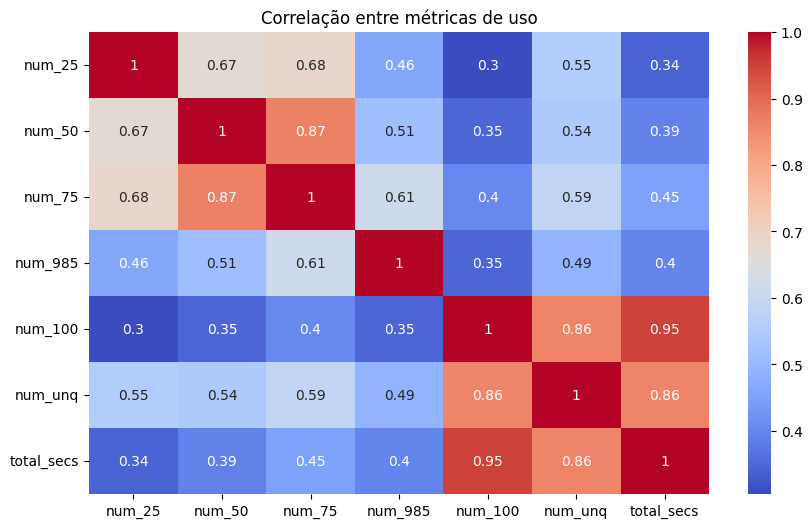

In [ ]:
sample_df = df_user_logs_new.select(numeric_cols).sample(fraction=0.01).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(sample_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlação entre métricas de uso")
plt.show()

num_100, num_unq e total_secs são fortes candidatos a features finais de engajamento.

Variáveis num_25, num_50, num_75 ainda ajudam, mas são menos diretamente ligadas ao volume real de uso.

num_985 parece "intermediária" — boa para capturar nuance.

In [ ]:
df_user_logs.select("msno").distinct().count()

from pyspark.sql.functions import countDistinct

df_user_logs_new.groupBy("msno").count().selectExpr("percentile(count, array(0.5)) as med_linhas_por_usuario").show()

+----------------------+
|med_linhas_por_usuario|
+----------------------+
|                 [1.0]|
+----------------------+



In [ ]:
df_user_logs_new.groupBy("safra").count().orderBy("safra").show(30)

+------+-------+
| safra|  count|
+------+-------+
|201501| 937786|
|201502| 933039|
|201503| 944736|
|201504| 938737|
|201505| 918860|
|201506| 910506|
|201507| 863466|
|201508| 911742|
|201509| 894810|
|201510|1009694|
|201511|1041377|
|201512|1038920|
|201601|1076534|
|201602|1041150|
|201603|1048844|
|201604|1042349|
|201605|1056491|
|201606|1081181|
|201607|1102807|
|201608|1103078|
|201609|1112601|
|201610|1139089|
|201611|1183088|
|201612|1135573|
|201701|1136003|
|201702|1114164|
+------+-------+



## Base Transactions

Coluna	Descrição
* msno	Identificador do usuário
* payment_method_id	ID do método de pagamento
* payment_plan_days	Duração do plano em dias (ex: 30, 365)
* plan_list_price	Preço "cheio" do plano
* actual_amount_paid	Valor realmente pago (com desconto ou não)
* is_auto_renew	Flag de renovação automática
* transaction_date	Data da transação
* membership_expire_date	Data de expiração da assinatura
* is_cancel	Cancelamento (1 = sim)

In [ ]:
df_transactions = spark.read.parquet(f"{path}/transactions.parquet")

In [ ]:
df_transactions.printSchema()
df_transactions.limit(5).toPandas()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- safra: integer (nullable = true)



,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,safra
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788,1788,0,20151121,20170104,0,201511
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20150526,20150626,0,201505
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20150926,20151026,0,201509
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,20160615,20160715,0,201606
4,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,40,31,149,149,1,20150113,20150216,0,201501


verificar nulos

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

df_transactions.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c + "_nulls") for c in df_transactions.columns
]).toPandas()

,msno_nulls,payment_method_id_nulls,payment_plan_days_nulls,plan_list_price_nulls,actual_amount_paid_nulls,is_auto_renew_nulls,transaction_date_nulls,membership_expire_date_nulls,is_cancel_nulls,safra_nulls
0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_transactions.select(
    "payment_plan_days", "plan_list_price", "actual_amount_paid"
).summary("count", "mean", "min", "max", "stddev").toPandas()

,summary,payment_plan_days,plan_list_price,actual_amount_paid
0,count,20712225,20712225,20712225
1,mean,31.428997850303382,140.24088353617248,142.83468555406287
2,min,0,0,0
3,max,99,99,99
4,stddev,30.559829808398856,132.27679209056222,133.60944276809983


max 99 acima da média - possivel erro

In [ ]:
from pyspark.sql.functions import max

df_transactions.select(
    max("plan_list_price"), max("actual_amount_paid")
).show()

+--------------------+-----------------------+
|max(plan_list_price)|max(actual_amount_paid)|
+--------------------+-----------------------+
|                  99|                     99|
+--------------------+-----------------------+



In [ ]:
from pyspark.sql.functions import col
df_transactions = df_transactions.withColumn("plan_list_price", col("plan_list_price").cast("double"))
df_transactions = df_transactions.withColumn("actual_amount_paid", col("actual_amount_paid").cast("double"))


In [ ]:
df_transactions.select(
    "payment_plan_days", "plan_list_price", "actual_amount_paid"
).summary("count", "mean", "min", "max", "stddev").toPandas()

,summary,payment_plan_days,plan_list_price,actual_amount_paid
0,count,20712225,20712225,20712225
1,mean,31.428997850303382,140.24088353617248,142.83468555406287
2,min,0,0.0,0.0
3,max,99,2000.0,2000.0
4,stddev,30.559829808398856,132.27679209056222,133.60944276809983


distribuição  valores planos

In [ ]:
df_transactions.groupBy("plan_list_price").count().orderBy("count", ascending = False).show(50)

+---------------+--------+
|plan_list_price|   count|
+---------------+--------+
|          149.0|11991932|
|           99.0| 4774736|
|            0.0| 1400016|
|          129.0| 1096728|
|          180.0|  656971|
|          150.0|  360939|
|          894.0|  107883|
|         1788.0|   78943|
|          100.0|   75569|
|          536.0|   42850|
|          119.0|   29215|
|          480.0|   22736|
|         1599.0|   11369|
|          477.0|   10752|
|          799.0|    6221|
|          300.0|    5342|
|          120.0|    5321|
|         1200.0|    5275|
|          298.0|    5167|
|          930.0|    5026|
|           35.0|    4144|
|          447.0|    3805|
|          134.0|    3567|
|          450.0|    1334|
|          500.0|    1094|
|          699.0|     889|
|           50.0|     748|
|         1000.0|     711|
|          124.0|     596|
|          350.0|     549|
|          131.0|     373|
|          400.0|     307|
|          105.0|     237|
|           70.0|     195|
|

será feito um teste de feature considerando faixas de preço

avaliação descontos

In [ ]:
from pyspark.sql.functions import expr

df_transactions = df_transactions.withColumn("teve_desconto", expr("actual_amount_paid < plan_list_price"))
df_transactions.groupBy("teve_desconto").count().show()

+-------------+--------+
|teve_desconto|   count|
+-------------+--------+
|         true|  759467|
|        false|19952758|
+-------------+--------+



imensa maioria dos usuários não teve desocnto mas é possíve usar essa informação como feature

pagamento a mais?

In [ ]:
df_transactions.filter(col("actual_amount_paid") > col("plan_list_price")).count()

837911

In [ ]:
df_transactions.filter(col("actual_amount_paid") > col("plan_list_price")).count()/df_transactions.count()

0.04045490042716318

Avaliação ids pagamento

In [ ]:
df_transactions.groupBy("payment_method_id").count().orderBy("count", ascending=False).show()
df_transactions.groupBy("payment_plan_days").count().orderBy("payment_plan_days").show()

+-----------------+--------+
|payment_method_id|   count|
+-----------------+--------+
|               41|11026911|
|               40| 2160126|
|               38| 1618337|
|               39| 1437059|
|               37|  991185|
|               36|  816661|
|               34|  728384|
|               35|  492261|
|               33|  402388|
|               31|  248960|
|               30|  150972|
|               32|  144037|
|               29|  108713|
|               28|   92752|
|               27|   60532|
|               23|   40594|
|               19|   32045|
|               20|   27977|
|               21|   22839|
|               22|   19973|
+-----------------+--------+
only showing top 20 rows

+-----------------+--------+
|payment_plan_days|   count|
+-----------------+--------+
|                0|  848204|
|                1|    2875|
|               10|   22538|
|              100|   23828|
|              110|     155|
|              120|    9882|
|               1

In [ ]:
from pyspark.sql.functions import expr

df_transactions = df_transactions.withColumn(
    "tem_desconto", expr("actual_amount_paid < plan_list_price")
)
df_transactions.groupBy("tem_desconto").count().show()

+------------+--------+
|tem_desconto|   count|
+------------+--------+
|        true|  759467|
|       false|19952758|
+------------+--------+



In [ ]:
from pyspark.sql.functions import to_date

df_transactions = df_transactions.withColumn("transaction_date", to_date(col("transaction_date").cast("string"), "yyyyMMdd"))
df_transactions = df_transactions.withColumn("membership_expire_date", to_date(col("membership_expire_date").cast("string"), "yyyyMMdd"))

In [ ]:
from pyspark.sql.functions import date_format

df_transactions.groupBy(date_format("transaction_date", "yyyyMM").alias("safra")).count().orderBy("safra").show()

+------+------+
| safra| count|
+------+------+
|201501|548792|
|201502|545303|
|201503|626488|
|201504|564582|
|201505|571552|
|201506|775737|
|201507|665280|
|201508|705975|
|201509|714610|
|201510|680465|
|201511|820345|
|201512|861107|
|201601|856716|
|201602|792300|
|201603|775469|
|201604|774169|
|201605|783956|
|201606|804729|
|201607|924032|
|201608|966450|
+------+------+
only showing top 20 rows



prox passos:
* construção da variave churn
* construção da base final e feature engineering
* treino/teste/oot
* modelagem
